# QUAC 609 Quantum Software II - Lab 2
## Practical Entanglement Distillation – Optimization Strategy

### Name: Francisco Granda


## Section 1 - Background on Optimization Problems and Fitness Landscapes

Optimization problems are fundamental in mathematics, engineering, and computer science, involving the search for the best solution among a set of solutions. A crucial concept in optimization is the fitness landscape, which represents how different solutions perform relative to an objective function.

Fitness landscapes can be categorized as rugged, smooth, or neutral, each affecting the complexity of finding optimal solutions. Rugged landscapes contain multiple local optima, making gradient-based approaches challenging. Smooth landscapes allow for easier traversal using calculus-based methods, while neutral landscapes exhibit large plateaus where many solutions have similar fitness values [1].

Another critical distinction is between local and global optima. A local optimum is a solution better than its immediate neighbors but not necessarily the best, while the global optimum is the best possible solution. Identifying global optima is challenging, particularly in high-dimensional and non-convex problems. Techniques like simulated annealing and genetic algorithms help navigate complex fitness landscapes to escape local optima and move toward the global solution [2].

The significance of fitness landscapes lies in their ability to guide optimization strategies. By understanding the landscape's characteristics, one can choose appropriate algorithms, such as heuristic methods for rugged landscapes and gradient-based approaches for smooth ones.

## Section 2 - Key Differences Between Optimization Problems

Optimization problems can be classified based on their structure and objectives. One fundamental distinction is between discrete and continuous optimization:

**- Discrete Optimization**: The solution space consists of distinct elements, such as in combinatorial problems. Integer programming and constraint satisfaction problems fall under this category [3].

**- Continuous Optimization**: The solution space is continuous, often requiring calculus-based techniques like gradient descent and Newton’s method. These methods are widely used in machine learning and physics simulations [4].

Another classification is between single-objective and multi-objective optimization:

**- Single-Objective Optimization**: Focuses on optimizing a single function, commonly encountered in machine learning models that minimize loss functions.

**- Multi-Objective Optimization**: Involves optimizing multiple conflicting objectives, requiring techniques such as Pareto front analysis and evolutionary algorithms to balance trade-offs between objectives [5].

## Section 3 - Selection of Optmization Strategy

Recent advancements in quantum computing have introduced new ideas for optimization. Quantum-inspired and quantum-based approaches offer potential speedups over classical methods, particularly for complex combinatorial problems.

One such method is the Quantum Approximate Optimization Algorithm (QAOA), which leverages quantum variational circuits to solve discrete optimization problems efficiently. QAOA utilizes a parameterized quantum circuit, where an ansatz (a pre-defined variational form) is optimized using classical techniques to find near-optimal solutions. QAOA also employs a drive Hamiltonian, which governs the evolution of the quantum state and helps navigate the optimization landscape efficiently [1].

Several types of ansatz can be used in variational quantum algorithms:

**- QAOA Ansatz**: Specifically designed for combinatorial optimization, using a problem Hamiltonian and a drive Hamiltonian to guide the evolution.

**- NLocal Ansatz**: A flexible variational form that incorporates local interactions, making it suitable for a wide range of problems.

**- EfficientSU Ansatz**: Designed for hardware-efficient implementations, reducing the number of required quantum gates.

**- Quantum Neural Network (QNN) Ansatz**: Inspired by classical neural networks, are used for machine learning and complex function approximation tasks.

Hybrid quantum-classical involve variational quantum circuits where classical optimizers refine quantum-encoded solutions iteratively. Such approaches are particularly effective in domains where classical heuristics struggle with complexity[3].

## Section 4 - Methodology Implementation Using Qiskit and Scipy

## 4.1 Strategy 1 - QNN and Classical Optimizer
This strategy follows the implementation presented in Lab 1 where a QNN circuit was proposed for the local operations on the qubits held by Alice and Bob. This approach will be the baseline for comparison with the other three strategies presented in this project. For this, we summarize the implementation in Lab 1 and start presenting the circuit that will be used for the optimization process:

In [1]:
# Required imports for Lab 2
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import DensityMatrix, partial_trace, SparsePauliOp
import numpy as np
from qiskit.circuit.library import QAOAAnsatz, NLocal, CCXGate, CRZGate, RXGate, EfficientSU2
import matplotlib.pyplot as plt

In [2]:
# Function to create a Bell state between two qubits
def create_bell_state_cont(num_qubits):
    if num_qubits % 2 != 0:
        raise ValueError("Number of qubits must be even to create Bell states on each pair.")
    
    qc = QuantumCircuit()
    alice = QuantumRegister(num_qubits // 2, 'Alice')
    bob = QuantumRegister(num_qubits // 2, 'Bob')
    qc.add_register(alice)
    qc.add_register(bob)
    for i in range(0, num_qubits, 2):
        qc.h(i)  # Apply Hadamard gate to qubit i
        qc.cx(i, i+1)  # Apply CNOT gate with control=i and target=i+1
    return qc

In [3]:
# Function to create initial state for a number of qubit pairs and a given fidelity
def create_initial_state(num_pairs, prob):
    # Create a Bell state circuit with 2 qubits
    qc = create_bell_state_cont(2)
    
    # Define the dimension of the density matrix
    dim = 2 ** (2)

    # Convert the Bell state circuit to a density matrix
    bell_density_matrix = DensityMatrix(qc)
    
    # Create isotropic state with specified probability
    iso_state = prob * bell_density_matrix + (1 - prob) * np.eye(dim) / dim

    # Initialize the final matrix with the density matrix of the Bell state
    final_matrix = iso_state
    
    # Perform the Kronecker product of the density matrix with itself num_pairs-1 times
    for _ in range(num_pairs - 1):
        final_matrix = np.kron(final_matrix, iso_state)
    
    if num_pairs == 1:
        return final_matrix.data
    else:
        return final_matrix

In [4]:
prob = 0.7
num_pairs = 4
initial_state_matrix = create_initial_state(num_pairs, prob)

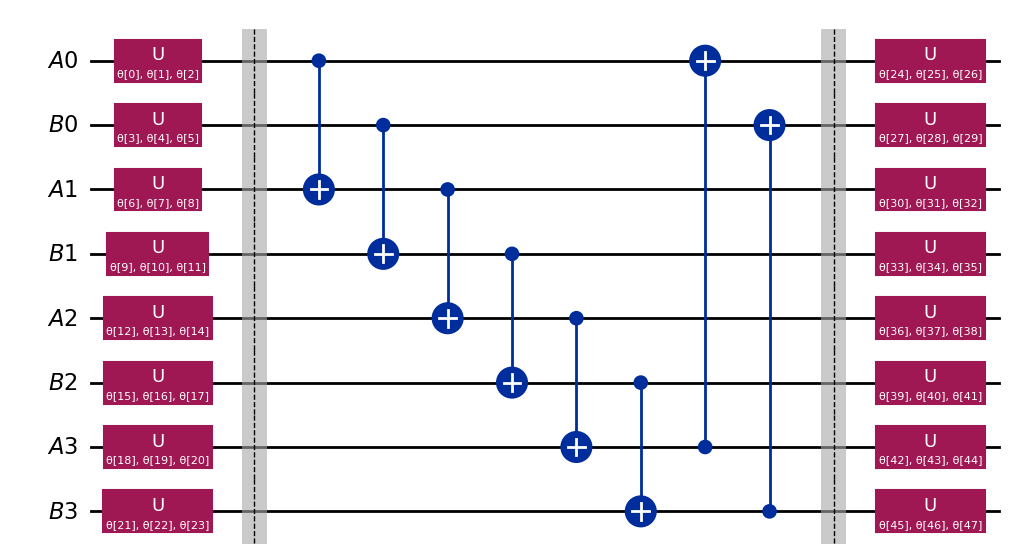

In [5]:
def qnn_circuit_u3(num_pairs, angles=None):

    num_qubits = num_pairs * 2
    theta_list = ParameterVector('θ', length=num_qubits * 6)  # Adjusted for three parameters per qubit
    qc = QuantumCircuit()
    
    # Create registers for Alice and Bob
    for i in range(num_pairs):
        alice = QuantumRegister(1, f'A{i}')
        bob = QuantumRegister(1, f'B{i}')
        qc.add_register(alice)
        qc.add_register(bob)
    
    # Apply initial layer of Rotations
    for i in range(num_qubits):
        qc.u(theta_list[3*i], theta_list[3*i+1], theta_list[3*i+2], i)
    
    qc.barrier()

    # Apply CNOT gates within Alice's and Bob's registers
    for i in range(num_pairs - 1):
        qc.cx(qc.qubits[2*i], qc.qubits[2*(i+1)])  # CNOT between A[i] and A[i+1]
        qc.cx(qc.qubits[2*i+1], qc.qubits[2*(i+1)+1])  # CNOT between B[i] and B[i+1]
    
    # Apply the last CNOT for circle entanglement from A[num_pairs-1] to A[0]
    qc.cx(qc.qubits[2*(num_pairs-1)], qc.qubits[0])  # CNOT between A[num_pairs-1] and A[0]
    qc.cx(qc.qubits[2*(num_pairs-1)+1], qc.qubits[1])  # CNOT between B[num_pairs-1] and B[0]

    qc.barrier()
    
    # Apply second layer of Rotations
    for i in range(num_qubits):
        qc.u(theta_list[num_qubits*3 + 3*i], theta_list[num_qubits*3 + 3*i+1], theta_list[num_qubits*3 + 3*i+2], i)
    
    return qc

# Initialize parameters array to random values
initial_angles = np.random.uniform(0, np.pi, 48)  # Adjusted for three parameters per qubit for two layers

test_qc = qnn_circuit_u3(4, initial_angles)
test_qc.draw('mpl')

Now, we prepare the optimization process using the COBYLA optimizer and observe the results:

In [6]:
from scipy.optimize import minimize

iterations = 0
loss_values = []

def loss_function_qnn(params, num_measurements=1000, desired_successful_cases=8):
    global iterations
    successful_cases = ["000000", "000011", "001100", "110000", "001111", "111100", "110011", "111111"]
    counts = 0
    loss = 0
    target_state = DensityMatrix(create_bell_state_cont(2))
    
    # Assign the parameters to the quantum circuit
    test_qc = qnn_circuit_u3(4, params)
    test_qc = test_qc.assign_parameters(params)
    
    # Initialize the state
    init_matrix = DensityMatrix(initial_state_matrix)
    init_matrix = init_matrix.evolve(test_qc)  # Apply the QNN circuit to the initial state

    init_matrix.seed(0)
    for _ in range(num_measurements):
        outcome, ret = init_matrix.measure([2, 3, 4, 5, 6, 7])
        if outcome in successful_cases:
            rho_ab = partial_trace(ret, [2, 3, 4, 5, 6, 7]).data
            loss += 1 - np.real(DensityMatrix(np.matmul(target_state.data, rho_ab)).trace())
            counts += 1
            if counts >= desired_successful_cases:
                break
    
    iterations += 1
    loss_values.append(loss)
    if iterations % 10 == 0:
        print("Iteration: ", iterations, " Loss: ", loss)
    return loss

In [7]:
# Using scipy optimizer
initial_angles = np.random.uniform(0, np.pi, 48)
result = minimize(loss_function_qnn, initial_angles, method='COBYLA', tol=1e-1, options={'maxiter': 2000, 'disp': False})
print("Optimized parameters:", result.x)
print("Minimum loss:", result.fun)

Iteration:  10  Loss:  5.119733545129431
Iteration:  20  Loss:  4.68716974612476
Iteration:  30  Loss:  3.2605343742786745
Iteration:  40  Loss:  2.886607647132972
Iteration:  50  Loss:  3.624408482990378
Iteration:  60  Loss:  2.660738890673358
Iteration:  70  Loss:  1.9420175766395926
Iteration:  80  Loss:  3.212753961180869
Iteration:  90  Loss:  2.1620213998202824
Iteration:  100  Loss:  2.1596714745130003
Iteration:  110  Loss:  2.8581892386630057
Iteration:  120  Loss:  2.746936592480222
Iteration:  130  Loss:  1.975401190202556
Iteration:  140  Loss:  1.7497105228806928
Iteration:  150  Loss:  1.7390145797164434
Iteration:  160  Loss:  1.7596832761509122
Iteration:  170  Loss:  1.7162392893336214
Iteration:  180  Loss:  1.6866046710741636
Iteration:  190  Loss:  1.6763034084409876
Iteration:  200  Loss:  1.6104187042218125
Iteration:  210  Loss:  1.5963045343318631
Iteration:  220  Loss:  1.5683604321881857
Iteration:  230  Loss:  1.5908623654022647
Iteration:  240  Loss:  1.587

In [8]:
# Calculate input state fidelity
fidelity_in = (3 * prob + 1) / 4
# Calculate output state fidelity
selected_successful_cases = 8
fidelity = (selected_successful_cases - result.fun) / selected_successful_cases

print("The fidelity of the input quantum state is：%.5f" % fidelity_in)
print("The fidelity of the purified quantum state is： %.5f" % fidelity)

The fidelity of the input quantum state is：0.77500
The fidelity of the purified quantum state is： 0.81442


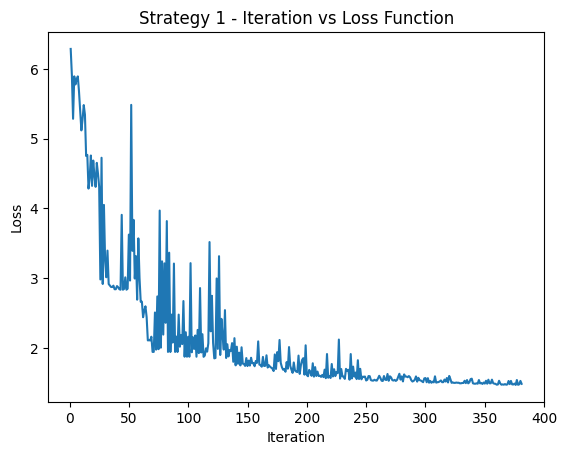

In [9]:
# Plot iteration vs loss
plt.plot(range(1, iterations + 1), loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Strategy 1 - Iteration vs Loss Function')
plt.show()

## 4.2 Strategy 2 - QAOA and Classical Optimizer
For the second strategy, we propose the use of the Quantum Approximate Optimization Algorithm (QAOA) for optimizing the distillation process. For this, we need to create a QAOA Ansatz that will be used as the local operations on the qubits held by Alice and Bob. This circuit will make use of a drive Hamiltonian with ZZ and XX interactions. Similar to the first strategy, the COBYLA optimizer will be used to minimize the loss function and observe the results:

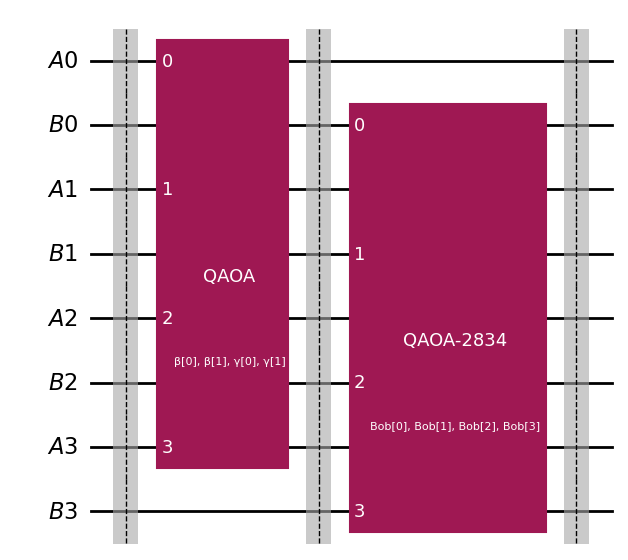

In [10]:
def qaoa_circuit(num_pairs, angles=None):

    num_qubits = num_pairs * 2
    qc = QuantumCircuit()
    
    # Create registers for Alice and Bob
    for i in range(num_pairs):
        alice = QuantumRegister(1, f'A{i}')
        bob = QuantumRegister(1, f'B{i}')
        qc.add_register(alice)
        qc.add_register(bob)

    # Define a simple cost Hamiltonian (ZZ interactions)
    num_layers = 2
    cost_paulis = ["ZZII", "IZZI", "IIZZ"]
    cost_coeffs = [1.0, 1.0, 1.0]  
    cost_hamiltonian = SparsePauliOp(cost_paulis, cost_coeffs)

    # Define an entangling mixer (XX terms between qubit pairs)
    mixer_paulis = ["XXII", "IXXI", "IIXX"]
    mixer_coeffs = [1.0, 1.0, 1.0]  
    mixer_hamiltonian = SparsePauliOp(mixer_paulis, mixer_coeffs)

    # Create the QAOA ansatz with the custom entangling mixer
    qaoa_ansatz_A = QAOAAnsatz(cost_operator=cost_hamiltonian, mixer_operator=mixer_hamiltonian, reps=num_layers)
    
    # Rename Bob circuit parameters to avoid conflicts
    gammas = ParameterVector("Bob", num_layers * num_qubits)

    qaoa_ansatz_B = qaoa_ansatz_A.assign_parameters(dict(zip(qaoa_ansatz_A.parameters, gammas)))
    qc.barrier()

    # Add QAOA Circuit to Alice Qubits
    qc.append(qaoa_ansatz_A, [0,2,4,6])
    qc.barrier()

    # Add QAOA Circuit to BOB Qubits
    qc.append(qaoa_ansatz_B, [1,3,5,7])
    qc.barrier()

    return qc

# Initialize parameters array to random values
initial_angles = np.random.uniform(0, np.pi, 48)  # Adjusted for three parameters per qubit for two layers

test_qc = qaoa_circuit(4, initial_angles)
test_qc.draw('mpl')

In [11]:
iterations = 0
loss_values = []

def loss_function_qaoa(params, num_measurements=1000, desired_successful_cases=8):
    global iterations
    successful_cases = ["000000", "000011", "001100", "110000", "001111", "111100", "110011", "111111"]
    counts = 0
    loss = 0
    target_state = DensityMatrix(create_bell_state_cont(2))
    
    # Assign the parameters to the quantum circuit
    test_qc = qaoa_circuit(4, params)
    test_qc = test_qc.assign_parameters(params)
    
    # Initialize the state
    init_matrix = DensityMatrix(initial_state_matrix)
    init_matrix = init_matrix.evolve(test_qc)  # Apply the QNN circuit to the initial state

    init_matrix.seed(0)
    for _ in range(num_measurements):
        outcome, ret = init_matrix.measure([2, 3, 4, 5, 6, 7])
        if outcome in successful_cases:
            rho_ab = partial_trace(ret, [2, 3, 4, 5, 6, 7]).data
            loss += 1 - np.real(DensityMatrix(np.matmul(target_state.data, rho_ab)).trace())
            counts += 1
            if counts >= desired_successful_cases:
                break
    
    iterations += 1
    loss_values.append(loss)
    if iterations % 10 == 0:
        print("Iteration: ", iterations, " Loss: ", loss)
    return loss

In [12]:
# Using scipy optimizer
initial_angles = np.random.uniform(0, np.pi, 8)
result = minimize(loss_function_qaoa, initial_angles, method='COBYLA', tol=1e-2, options={'maxiter': 2000, 'disp': False})
print("Optimized parameters:", result.x)
print("Minimum loss:", result.fun)

Iteration:  10  Loss:  6.763078123070967
Iteration:  20  Loss:  1.9377161556410392
Iteration:  30  Loss:  2.1252116375970997
Iteration:  40  Loss:  1.566153963174431


Iteration:  50  Loss:  1.3895415041533425
Iteration:  60  Loss:  1.0550017876838083
Iteration:  70  Loss:  0.869710716943635
Iteration:  80  Loss:  0.545165040698155
Iteration:  90  Loss:  0.5122730800209343
Iteration:  100  Loss:  0.5066951872547888
Iteration:  110  Loss:  0.5050753737168172
Optimized parameters: [ 3.14373703  2.35386293  2.65975891 -0.31308423  2.48516134  1.45344467
  0.78774151  3.14339606]
Minimum loss: 0.5056545571477841


In [13]:
# Calculate input state fidelity
fidelity_in = (3 * prob + 1) / 4
# Calculate output state fidelity
selected_successful_cases = 8
fidelity = (selected_successful_cases - result.fun) / selected_successful_cases

print("The fidelity of the input quantum state is：%.5f" % fidelity_in)
print("The fidelity of the purified quantum state is： %.5f" % fidelity)

The fidelity of the input quantum state is：0.77500
The fidelity of the purified quantum state is： 0.93679


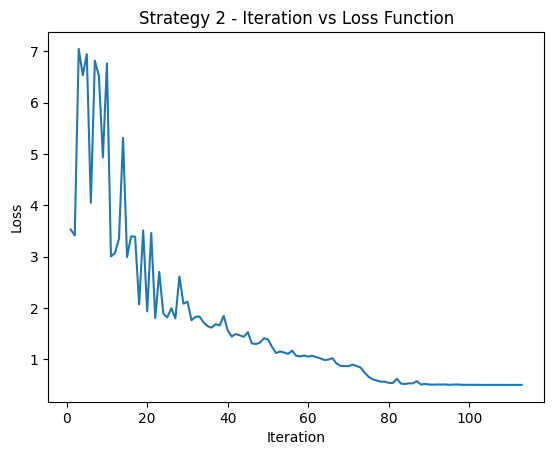

In [14]:
# Plot iteration vs loss
plt.plot(range(1, iterations + 1), loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Strategy 2 - Iteration vs Loss Function')
plt.show()

## 4.3 Strategy 3 - NLOCAL and Classical Optimizer
For the third strategy, we propose the use of a heuristic ansatz in the form of a NLocal circuit. This circuit is designed for high speed and accuracy by reducing the search space. Following a similar process as the first two strategies, we present the circuit first and the observe the results:

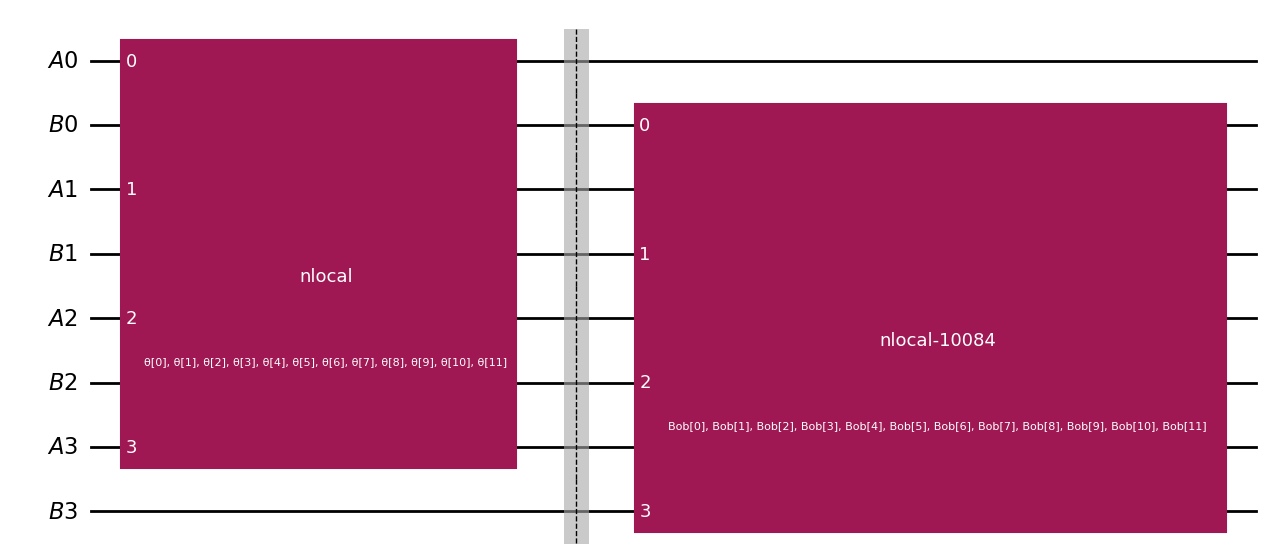

In [15]:
def nlocal_circuit(num_pairs, angles=None):

    num_layers = 1
    qc = QuantumCircuit()
    
    # Create registers for Alice and Bob
    for i in range(num_pairs):
        alice = QuantumRegister(1, f'A{i}')
        bob = QuantumRegister(1, f'B{i}')
        qc.add_register(alice)
        qc.add_register(bob)

    # Create NLocal Parametrized Circuit
    theta = Parameter("θ")
    ansatz_A = NLocal(
        num_qubits=num_pairs,
        rotation_blocks=[RXGate(theta), CRZGate(theta)],
        entanglement_blocks=CCXGate(),
        entanglement = [[0, 1, 2], [0, 2, 3], [3, 1, 0]],
        reps=num_layers,
        insert_barriers=True,
    )

    # Rename Bob circuit parameters to avoid conflicts
    gammas = ParameterVector("Bob", len(ansatz_A.parameters))
    ansatz_B = ansatz_A.assign_parameters(dict(zip(ansatz_A.parameters, gammas)))

    # Add QAOA Circuit to Alice Qubits
    qc.append(ansatz_A, [0,2,4,6])
    qc.barrier()

    # Add QAOA Circuit to BOB Qubits
    qc.append(ansatz_B, [1,3,5,7])

    return qc

# Initialize parameters array to random values
initial_angles = np.random.uniform(0, np.pi, 24)  # Adjusted for three parameters per qubit for two layers

test_qc = nlocal_circuit(4, initial_angles)
test_qc.draw('mpl')

In [16]:
iterations = 0
loss_values = []

def loss_function_nlocal(params, num_measurements=1000, desired_successful_cases=8):
    global iterations
    successful_cases = ["000000", "000011", "001100", "110000", "001111", "111100", "110011", "111111"]
    counts = 0
    loss = 0
    target_state = DensityMatrix(create_bell_state_cont(2))
    
    # Assign the parameters to the quantum circuit
    test_qc = nlocal_circuit(4, params)
    test_qc = test_qc.assign_parameters(params)
    
    # Initialize the state
    init_matrix = DensityMatrix(initial_state_matrix)
    init_matrix = init_matrix.evolve(test_qc)  # Apply the QNN circuit to the initial state

    init_matrix.seed(0)
    for _ in range(num_measurements):
        outcome, ret = init_matrix.measure([2, 3, 4, 5, 6, 7])
        if outcome in successful_cases:
            rho_ab = partial_trace(ret, [2, 3, 4, 5, 6, 7]).data
            loss += 1 - np.real(DensityMatrix(np.matmul(target_state.data, rho_ab)).trace())
            counts += 1
            if counts >= desired_successful_cases:
                break
    
    iterations += 1
    loss_values.append(loss)
    if iterations % 10 == 0:
        print("Iteration: ", iterations, " Loss: ", loss)
    return loss

In [17]:
# Using scipy optimizer
initial_angles = np.random.uniform(0, np.pi, 24)
result = minimize(loss_function_nlocal, initial_angles, method='COBYLA', tol=1e-2, options={'maxiter': 2000, 'disp': False})
print("Optimized parameters:", result.x)
print("Minimum loss:", result.fun)

Iteration:  10  Loss:  5.882779551124241


Iteration:  20  Loss:  5.323992761591165
Iteration:  30  Loss:  5.229554689229041
Iteration:  40  Loss:  5.428652775972801
Iteration:  50  Loss:  5.0988070256178295
Iteration:  60  Loss:  4.798400732987179
Iteration:  70  Loss:  4.581137034950275
Iteration:  80  Loss:  4.2480236176909925
Iteration:  90  Loss:  4.550792782349646
Iteration:  100  Loss:  4.239815717443701
Iteration:  110  Loss:  4.1645497222653525
Iteration:  120  Loss:  4.1347838460383635
Iteration:  130  Loss:  4.099582302345245
Iteration:  140  Loss:  4.047512177681101
Iteration:  150  Loss:  4.037329917857993
Iteration:  160  Loss:  4.028921372188101
Iteration:  170  Loss:  3.989034034760923
Iteration:  180  Loss:  3.9604667067701316
Iteration:  190  Loss:  3.9593493292274546
Iteration:  200  Loss:  3.9650704896984124
Iteration:  210  Loss:  3.953028500473292
Iteration:  220  Loss:  3.9334415474106934
Iteration:  230  Loss:  3.9335253295129324
Iteration:  240  Loss:  4.261634349716765
Iteration:  250  Loss:  3.9240426

In [18]:
# Calculate input state fidelity
fidelity_in = (3 * prob + 1) / 4
# Calculate output state fidelity
selected_successful_cases = 8
fidelity = (selected_successful_cases - result.fun) / selected_successful_cases

print("The fidelity of the input quantum state is：%.5f" % fidelity_in)
print("The fidelity of the purified quantum state is： %.5f" % fidelity)

The fidelity of the input quantum state is：0.77500
The fidelity of the purified quantum state is： 0.50941


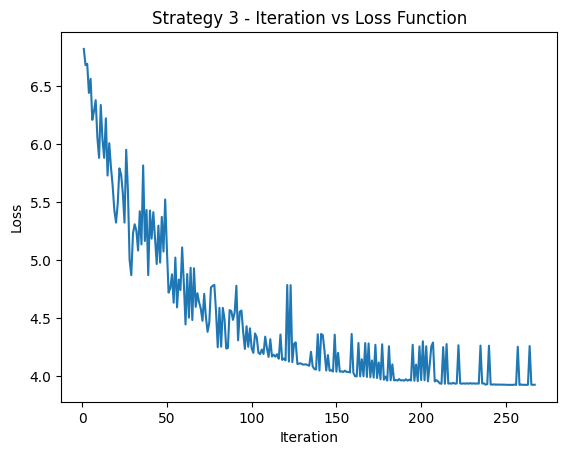

In [19]:
# Plot iteration vs loss
plt.plot(range(1, iterations + 1), loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Strategy 3 - Iteration vs Loss Function')
plt.show()

## 4.4 Strategy 4 - EfficientSU2 and Classical Optimizer
For the last strategy, we follow a similar approach as the previous optimization strategies but plug in a different heuristic ansatz in the form of the EfficientSU2 to observe any changes in performance:

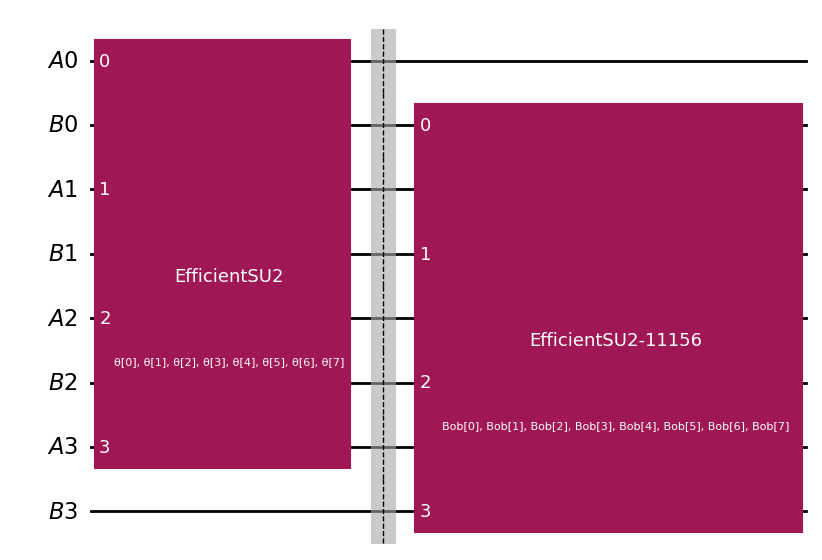

In [20]:
def efficient_circuit(num_pairs, angles=None):

    num_layers = 1
    qc = QuantumCircuit()
    
    # Create registers for Alice and Bob
    for i in range(num_pairs):
        alice = QuantumRegister(1, f'A{i}')
        bob = QuantumRegister(1, f'B{i}')
        qc.add_register(alice)
        qc.add_register(bob)

    # Create EfficientSU2 Parametrized Circuit
    ansatz_A = EfficientSU2(num_pairs, su2_gates=["rx", "y"], entanglement="linear", reps=num_layers)

    # Rename Bob circuit parameters to avoid conflicts
    gammas = ParameterVector("Bob", len(ansatz_A.parameters))
    ansatz_B = ansatz_A.assign_parameters(dict(zip(ansatz_A.parameters, gammas)))

    # Add QAOA Circuit to Alice Qubits
    qc.append(ansatz_A, [0,2,4,6])
    qc.barrier()

    # Add QAOA Circuit to BOB Qubits
    qc.append(ansatz_B, [1,3,5,7])

    return qc

# Initialize parameters array to random values
initial_angles = np.random.uniform(0, np.pi, 24)  # Adjusted for three parameters per qubit for two layers

test_qc = efficient_circuit(4, initial_angles)
test_qc.draw('mpl')

In [21]:
iterations = 0
loss_values = []

def loss_function_efficient(params, num_measurements=1000, desired_successful_cases=8):
    global iterations
    successful_cases = ["000000", "000011", "001100", "110000", "001111", "111100", "110011", "111111"]
    counts = 0
    loss = 0
    target_state = DensityMatrix(create_bell_state_cont(2))
    
    # Assign the parameters to the quantum circuit
    test_qc = efficient_circuit(4, params)
    test_qc = test_qc.assign_parameters(params)
    
    # Initialize the state
    init_matrix = DensityMatrix(initial_state_matrix)
    init_matrix = init_matrix.evolve(test_qc)  # Apply the QNN circuit to the initial state

    init_matrix.seed(0)
    for _ in range(num_measurements):
        outcome, ret = init_matrix.measure([2, 3, 4, 5, 6, 7])
        if outcome in successful_cases:
            rho_ab = partial_trace(ret, [2, 3, 4, 5, 6, 7]).data
            loss += 1 - np.real(DensityMatrix(np.matmul(target_state.data, rho_ab)).trace())
            counts += 1
            if counts >= desired_successful_cases:
                break
    
    iterations += 1
    loss_values.append(loss)
    if iterations % 10 == 0:
        print("Iteration: ", iterations, " Loss: ", loss)
    return loss

In [22]:
# Using scipy optimizer
initial_angles = np.random.uniform(0, np.pi, 16)
result = minimize(loss_function_efficient, initial_angles, method='COBYLA', tol=1e-2, options={'maxiter': 2000, 'disp': False})
print("Optimized parameters:", result.x)
print("Minimum loss:", result.fun)

Iteration:  10  Loss:  6.196865048295634


Iteration:  20  Loss:  2.2498468172641406
Iteration:  30  Loss:  1.7359609610470255
Iteration:  40  Loss:  1.591983734811726
Iteration:  50  Loss:  1.2058816612334518
Iteration:  60  Loss:  1.6172141700774816
Iteration:  70  Loss:  1.2027986618372513
Iteration:  80  Loss:  1.161064517201381
Iteration:  90  Loss:  1.1132604859768875
Iteration:  100  Loss:  1.10236320021275
Iteration:  110  Loss:  1.093069242879456
Iteration:  120  Loss:  1.0847323611856634
Iteration:  130  Loss:  1.082140376969983
Iteration:  140  Loss:  1.0820232086908321
Iteration:  150  Loss:  1.0797542519949
Iteration:  160  Loss:  1.0783744636931196
Iteration:  170  Loss:  1.077112237027693
Iteration:  180  Loss:  1.0769738471960428
Iteration:  190  Loss:  1.0766926564577988
Iteration:  200  Loss:  1.0759362260956236
Iteration:  210  Loss:  1.0757929675971862
Iteration:  220  Loss:  1.0754651432555322
Iteration:  230  Loss:  1.075144153763019
Iteration:  240  Loss:  1.0750745833316335
Iteration:  250  Loss:  1.0746

In [23]:
# Calculate input state fidelity
fidelity_in = (3 * prob + 1) / 4
# Calculate output state fidelity
selected_successful_cases = 8
fidelity = (selected_successful_cases - result.fun) / selected_successful_cases

print("The fidelity of the input quantum state is：%.5f" % fidelity_in)
print("The fidelity of the purified quantum state is： %.5f" % fidelity)

The fidelity of the input quantum state is：0.77500
The fidelity of the purified quantum state is： 0.87421


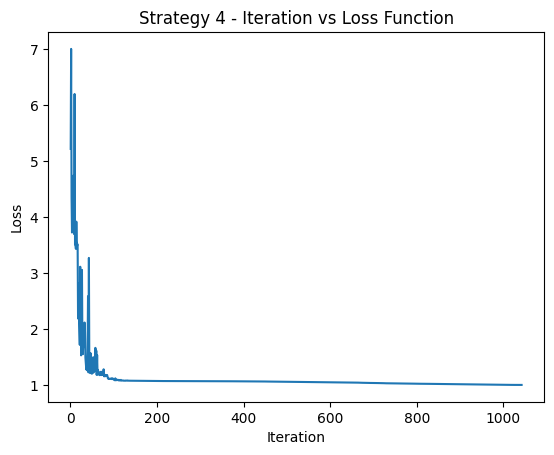

In [24]:
# Plot iteration vs loss
plt.plot(range(1, iterations + 1), loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Strategy 4 - Iteration vs Loss Function')
plt.show()

## Section 5 - Conclusions and Future Work

The results for the four strategies can be summarized in the following table:

|               | Strategy 1 | Strategy 2 | Strategy 3 | Strategy 4 |
|--------------|------------|--------------|-----------------|-----------|
| **Iterations** | < 400      | **< 110**       | < 300           | < 1200     |
| **Fidelity**  | 0.81442 | **0.93679**  | 0.50941     | 0.87421 |

Strategy 2 demonstrated the best optimization performance, achieving the highest fidelity value of 0.93679 with the fewest iterations among all tested approaches. The use of a QAOA Ansatz, combined with generic cost and mixer Hamiltonians to construct the parameterized optimization circuit, proved highly effective. This result highlights the potential of hybrid classical-quantum optimization schemes while emphasizing the need for further research and experimentation to identify optimal circuit configurations for specific use cases.

## Section 6 - References
[1] IBM Quantum Learning. "Ansatze and Variational Forms." Available at: https://learning.quantum.ibm.com/course/variational-algorithm-design/ansatze-and-variational-forms

[2] Farhi, E., Goldstone, J., & Gutmann, S. (2014). "A Quantum Approximate Optimization Algorithm." arXiv preprint arXiv:1411.4028.

[3] Bertsimas, D., & Tsitsiklis, J. (1997). "Introduction to Linear Optimization." Athena Scientific.

[4] Nocedal, J., & Wright, S. (2006). "Numerical Optimization." Springer Science & Business Media.

[5] Deb, K. (2001). "Multi-Objective Optimization Using Evolutionary Algorithms." John Wiley & Sons.